In [141]:
# Load in necessary packages

import pandas as pd

import matplotlib.pyplot as plt

In [142]:
# Read in the data from the .csv file

# This dataset covers US Police Shootings from 2015-2024. More information can be found at 
# https://www.kaggle.com/datasets/aquibahmad7/police-shootings-in-the-united-states-2015-2024?resource=download

data = pd.read_csv('C:/Users/bourb/OneDrive/Datasets/2024-07-23-washington-post-police-shootings-export.csv')

In [143]:
# Inspect the data to confirm successful load

data.head(3)

,date,name,age,gender,armed,race,city,state,flee,body_camera,signs_of_mental_illness,police_departments_involved
0,2015-01-02,Lewis Lee Lembke,47.0,male,gun,White,Aloha,OR,not,False,False,"Washington County Sheriff's Office, OR"
1,2015-01-02,Tim Elliot,53.0,male,gun,Asian,Shelton,WA,not,False,True,"Mason County Sheriff's Office, WA"
2,2015-01-03,John Paul Quintero,23.0,male,unarmed,Hispanic,Wichita,KS,not,False,False,"Wichita Police Department, KS"


In [144]:
# Check datatypes, row count, and # of non-null values in each column

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9893 entries, 0 to 9892
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         9893 non-null   object 
 1   name                         9556 non-null   object 
 2   age                          9509 non-null   float64
 3   gender                       9865 non-null   object 
 4   armed                        9682 non-null   object 
 5   race                         9893 non-null   object 
 6   city                         9821 non-null   object 
 7   state                        9893 non-null   object 
 8   flee                         8548 non-null   object 
 9   body_camera                  9893 non-null   bool   
 10  signs_of_mental_illness      9893 non-null   bool   
 11  police_departments_involved  9892 non-null   object 
dtypes: bool(2), float64(1), object(9)
memory usage: 792.3+ KB


In [145]:
# Inspect the rows with a null value in the name column 

data[data['name'].isna()]

,date,name,age,gender,armed,race,city,state,flee,body_camera,signs_of_mental_illness,police_departments_involved
930,2015-12-10,NaN,NaN,male,gun,Unknown,Hemet,CA,not,False,False,"Hemet Police Department, CA"
1419,2016-06-09,NaN,NaN,male,blunt_object,Unknown,Somerton,AZ,not,False,False,"U.S. Border Patrol, AZ"
1646,2016-09-01,NaN,NaN,male,blunt_object,Hispanic,Huntington Park,CA,not,False,False,"Huntington Park Police Department, CA"
1921,2016-12-20,NaN,NaN,male,knife,Unknown,Brawley,CA,not,False,True,"Brawley Police Department, CA"
2075,2017-02-09,NaN,NaN,male,undetermined,Unknown,Crownpoint,NM,NaN,False,False,"Navajo Nation Police Department, NM"
...,...,...,...,...,...,...,...,...,...,...,...,...
9872,2024-07-10,NaN,20.0,male,knife,Unknown,Muskegon,MI,foot,False,False,"Muskegon Police Department, MI"
9875,2024-07-10,NaN,NaN,male,gun,Unknown,Bedford,TX,NaN,False,False,"Bedford Police Department, TX;Hurst Police Dep..."
9883,2024-07-12,NaN,NaN,NaN,"vehicle,gun",Unknown,Midlothian,TX,car,False,False,"Dalworthington Gardens Police Department, TX;M..."
9886,2024-07-13,NaN,NaN,male,gun,Unknown,Los Angeles,CA,not,False,False,"Los Angeles Police Department, CA"


In [146]:
# Fill the nulls in the name column with the value 'Unknown'

data['name'] = data['name'].fillna('Unknown')

In [147]:
# Inspect the values that are now 'Unknown'...this is done mostly to confirm the row count matches that of the above DataFrame
# where these values were previously null. It is 337 in both dfs so it stands to reason that all nulls were replaced

data[data['name'] == 'Unknown']

,date,name,age,gender,armed,race,city,state,flee,body_camera,signs_of_mental_illness,police_departments_involved
930,2015-12-10,Unknown,NaN,male,gun,Unknown,Hemet,CA,not,False,False,"Hemet Police Department, CA"
1419,2016-06-09,Unknown,NaN,male,blunt_object,Unknown,Somerton,AZ,not,False,False,"U.S. Border Patrol, AZ"
1646,2016-09-01,Unknown,NaN,male,blunt_object,Hispanic,Huntington Park,CA,not,False,False,"Huntington Park Police Department, CA"
1921,2016-12-20,Unknown,NaN,male,knife,Unknown,Brawley,CA,not,False,True,"Brawley Police Department, CA"
2075,2017-02-09,Unknown,NaN,male,undetermined,Unknown,Crownpoint,NM,NaN,False,False,"Navajo Nation Police Department, NM"
...,...,...,...,...,...,...,...,...,...,...,...,...
9872,2024-07-10,Unknown,20.0,male,knife,Unknown,Muskegon,MI,foot,False,False,"Muskegon Police Department, MI"
9875,2024-07-10,Unknown,NaN,male,gun,Unknown,Bedford,TX,NaN,False,False,"Bedford Police Department, TX;Hurst Police Dep..."
9883,2024-07-12,Unknown,NaN,NaN,"vehicle,gun",Unknown,Midlothian,TX,car,False,False,"Dalworthington Gardens Police Department, TX;M..."
9886,2024-07-13,Unknown,NaN,male,gun,Unknown,Los Angeles,CA,not,False,False,"Los Angeles Police Department, CA"


In [148]:
# Again check '.info()' to confirm the name column now has no null values

data.info()

# I will skip the age column for now because of it's datatype. Filling with a string value is not appropriate, so I'll have to
# deal with null values there differently

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9893 entries, 0 to 9892
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         9893 non-null   object 
 1   name                         9893 non-null   object 
 2   age                          9509 non-null   float64
 3   gender                       9865 non-null   object 
 4   armed                        9682 non-null   object 
 5   race                         9893 non-null   object 
 6   city                         9821 non-null   object 
 7   state                        9893 non-null   object 
 8   flee                         8548 non-null   object 
 9   body_camera                  9893 non-null   bool   
 10  signs_of_mental_illness      9893 non-null   bool   
 11  police_departments_involved  9892 non-null   object 
dtypes: bool(2), float64(1), object(9)
memory usage: 792.3+ KB


In [149]:
# I've decided to also replace gender column nulls with 'unknown' however this time with a lowercase u to match the all lower
# case convention already established in the populated values in the column

data['gender'] = data['gender'].fillna('unknown')

In [150]:
# Confirm that all nulls in the gender column are handled 

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9893 entries, 0 to 9892
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         9893 non-null   object 
 1   name                         9893 non-null   object 
 2   age                          9509 non-null   float64
 3   gender                       9893 non-null   object 
 4   armed                        9682 non-null   object 
 5   race                         9893 non-null   object 
 6   city                         9821 non-null   object 
 7   state                        9893 non-null   object 
 8   flee                         8548 non-null   object 
 9   body_camera                  9893 non-null   bool   
 10  signs_of_mental_illness      9893 non-null   bool   
 11  police_departments_involved  9892 non-null   object 
dtypes: bool(2), float64(1), object(9)
memory usage: 792.3+ KB


In [151]:
# Inspect all unique values in the armed column to decide how to deal with nulls

data['armed'].unique()

array(['gun', 'unarmed', 'other', 'replica', 'knife', 'blunt_object', nan,
       'vehicle', 'undetermined', 'other,gun', 'unknown',
       'blunt_object,blunt_object', 'gun,knife', 'knife,blunt_object',
       'vehicle,gun', 'gun,vehicle', 'replica,vehicle',
       'blunt_object,knife', 'knife,vehicle', 'vehicle,knife,other',
       'knife,knife', 'replica,knife', 'other,blunt_object,knife',
       'other,knife', 'vehicle,knife', 'gun,other', 'blunt_object,other'],
      dtype=object)

In [152]:
# I've decided to fill the nulls with the value 'undetermined'

data['armed'] = data['armed'].fillna('undetermined')

In [153]:
# I also want to coerce the value 'unknown' to 'undetermined' and not deal with two different values for one phenomenon

data['armed'] = data['armed'].replace({'unknown': 'undetermined'})

In [154]:
# Inspect to confirm both NaN and 'unknown' are no longer present

data['armed'].unique()

array(['gun', 'unarmed', 'other', 'replica', 'knife', 'blunt_object',
       'undetermined', 'vehicle', 'other,gun',
       'blunt_object,blunt_object', 'gun,knife', 'knife,blunt_object',
       'vehicle,gun', 'gun,vehicle', 'replica,vehicle',
       'blunt_object,knife', 'knife,vehicle', 'vehicle,knife,other',
       'knife,knife', 'replica,knife', 'other,blunt_object,knife',
       'other,knife', 'vehicle,knife', 'gun,other', 'blunt_object,other'],
      dtype=object)

In [155]:
# Iterate through the values in the armed column looking for values with a ','. If ',' is found then replace the value with
# 'multiple weapons'

for value in data['armed']:
    if ',' in value:
        data ['armed'] = data['armed'].replace(value, 'multiple weapons')

In [156]:
# Confirm this cleanup with successful

data['armed'].unique()

array(['gun', 'unarmed', 'other', 'replica', 'knife', 'blunt_object',
       'undetermined', 'vehicle', 'multiple weapons'], dtype=object)

In [157]:
# Count the values in the armed column to assess the impact of creating the multiple weapons column. Since this substition
# represents < 1.5%  of values I find this to be an acceptable strategy. Though for the purposes of my testing I am accepting
# 'race' as the column name, if I were to present this data I would coerce this column name to something like 'count.'

data[['armed', 'race']].groupby('armed').count().sort_values(by='race', ascending=False)

,race
armed,
gun,5748
knife,1683
undetermined,780
unarmed,551
vehicle,351
replica,314
blunt_object,239
multiple weapons,129
other,98


In [158]:
# Inspect to confirm all null values in the 'armed' column have been handled

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9893 entries, 0 to 9892
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         9893 non-null   object 
 1   name                         9893 non-null   object 
 2   age                          9509 non-null   float64
 3   gender                       9893 non-null   object 
 4   armed                        9893 non-null   object 
 5   race                         9893 non-null   object 
 6   city                         9821 non-null   object 
 7   state                        9893 non-null   object 
 8   flee                         8548 non-null   object 
 9   body_camera                  9893 non-null   bool   
 10  signs_of_mental_illness      9893 non-null   bool   
 11  police_departments_involved  9892 non-null   object 
dtypes: bool(2), float64(1), object(9)
memory usage: 792.3+ KB


In [159]:
# I have decided to fill null city names to the value 'Unknown' 

data['city'] = data['city'].fillna('Unknown')

In [160]:
# Confirm these nulls have all been handled 

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9893 entries, 0 to 9892
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         9893 non-null   object 
 1   name                         9893 non-null   object 
 2   age                          9509 non-null   float64
 3   gender                       9893 non-null   object 
 4   armed                        9893 non-null   object 
 5   race                         9893 non-null   object 
 6   city                         9893 non-null   object 
 7   state                        9893 non-null   object 
 8   flee                         8548 non-null   object 
 9   body_camera                  9893 non-null   bool   
 10  signs_of_mental_illness      9893 non-null   bool   
 11  police_departments_involved  9892 non-null   object 
dtypes: bool(2), float64(1), object(9)
memory usage: 792.3+ KB


In [161]:
# Inspect unique values in the 'flee' column

data['flee'].unique()

array(['not', 'car', 'foot', 'other', nan], dtype=object)

In [162]:
# Print a sample of 25 values from this 'flee' column to get a taste of the regularity of values 

data['flee'].head(25)

0      not
1      not
2      not
3      not
4      not
5      not
6      car
7      not
8      not
9      not
10     not
11    foot
12     car
13     not
14     not
15     not
16     not
17     not
18     not
19     not
20     not
21    foot
22     not
23     not
24     not
Name: flee, dtype: object

In [163]:
data['flee'] = data['flee'].replace({'not':'did not flee'})

In [164]:
# I have decided to fill nulls with the value 'unknown'

data['flee'] = data['flee'].fillna('not reported')

In [165]:
# Confirm that all nulls in the 'flee' column have been handled 

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9893 entries, 0 to 9892
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         9893 non-null   object 
 1   name                         9893 non-null   object 
 2   age                          9509 non-null   float64
 3   gender                       9893 non-null   object 
 4   armed                        9893 non-null   object 
 5   race                         9893 non-null   object 
 6   city                         9893 non-null   object 
 7   state                        9893 non-null   object 
 8   flee                         9893 non-null   object 
 9   body_camera                  9893 non-null   bool   
 10  signs_of_mental_illness      9893 non-null   bool   
 11  police_departments_involved  9892 non-null   object 
dtypes: bool(2), float64(1), object(9)
memory usage: 792.3+ KB


In [166]:
# Since there is only one null in the 'police_departments_involved' column I wanted to find and inspect it to assess the
# irregularity.

data[data['police_departments_involved'].isna()]

,date,name,age,gender,armed,race,city,state,flee,body_camera,signs_of_mental_illness,police_departments_involved
9770,2024-06-10,Ridge Ryen Rhodes,29.0,male,gun,White,Lewistown,PA,did not flee,False,False,NaN


In [167]:
# Check to see if there is another row for this city (The state combination is also relevant here.) Since there is another
# record for Lewistown, PA I will coerce the unknown value to match this other record

data[data['city'] == 'Lewistown']

,date,name,age,gender,armed,race,city,state,flee,body_camera,signs_of_mental_illness,police_departments_involved
2278,2017-04-26,Charles Bossinger,53.0,male,gun,White,Lewistown,PA,did not flee,False,True,"Lewistown Borough Police Department, PA"
5139,2020-03-15,Douglas J. Foster,47.0,male,gun,White,Lewistown,MT,car,False,False,"Dillon Police Department, MT"
5781,2020-11-04,Justin Hammack,26.0,male,replica,White,Lewistown,IL,not reported,False,True,"Fulton County Sheriff's Department, IL;Lewisto..."
9770,2024-06-10,Ridge Ryen Rhodes,29.0,male,gun,White,Lewistown,PA,did not flee,False,False,NaN


In [168]:
# I decided to coerce to the department with the matching city, state combination.

data['police_departments_involved'] = data['police_departments_involved'].fillna('Lewistown Borough Police Department, PA')

In [169]:
# Confirm this worked as expected replacing the null value with the above identified department 

data[data['city'] == 'Lewistown']

,date,name,age,gender,armed,race,city,state,flee,body_camera,signs_of_mental_illness,police_departments_involved
2278,2017-04-26,Charles Bossinger,53.0,male,gun,White,Lewistown,PA,did not flee,False,True,"Lewistown Borough Police Department, PA"
5139,2020-03-15,Douglas J. Foster,47.0,male,gun,White,Lewistown,MT,car,False,False,"Dillon Police Department, MT"
5781,2020-11-04,Justin Hammack,26.0,male,replica,White,Lewistown,IL,not reported,False,True,"Fulton County Sheriff's Department, IL;Lewisto..."
9770,2024-06-10,Ridge Ryen Rhodes,29.0,male,gun,White,Lewistown,PA,did not flee,False,False,"Lewistown Borough Police Department, PA"


In [170]:
# At this point I just wanted to look at the top 10 departments with known shootings 

data[['police_departments_involved', 'race']].groupby('police_departments_involved').count().sort_values(by='race', ascending=False).head(10)

,race
police_departments_involved,
"Los Angeles Police Department, CA",139
"Phoenix Police Department, AZ",119
"Los Angeles County Sheriff's Department, CA",110
"Houston Police Department, TX",77
"San Antonio Police Department, TX",77
"New York Police Department, NY",77
"Las Vegas Metropolitan Police Department, NV",71
"San Bernardino County Sheriff's Department, CA",55
"Pennsylvania State Police, PA",55


In [171]:
# Inspect to assess our cleanup process 

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9893 entries, 0 to 9892
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         9893 non-null   object 
 1   name                         9893 non-null   object 
 2   age                          9509 non-null   float64
 3   gender                       9893 non-null   object 
 4   armed                        9893 non-null   object 
 5   race                         9893 non-null   object 
 6   city                         9893 non-null   object 
 7   state                        9893 non-null   object 
 8   flee                         9893 non-null   object 
 9   body_camera                  9893 non-null   bool   
 10  signs_of_mental_illness      9893 non-null   bool   
 11  police_departments_involved  9893 non-null   object 
dtypes: bool(2), float64(1), object(9)
memory usage: 792.3+ KB


In [172]:
# Inspect the unique values in the 'race' column 

data['race'].unique()

array(['White', 'Asian', 'Hispanic', 'Black', 'Other', 'Unknown',
       'Native American', 'White,Black,Native American',
       'Native American,Hispanic', 'White,Hispanic', 'Black,Hispanic',
       'White,Black'], dtype=object)

In [173]:
# I've decided to coerce values with a comma to be represented as 'Multiple Races' as opposed to the more unsightly values
# that are inherent to the column 

for value in data['race']:
    if ',' in value:
        data ['race'] = data['race'].replace(value, 'Multiple Races')

In [174]:
# Confirm that this worked as expected 

data['race'].unique()

array(['White', 'Asian', 'Hispanic', 'Black', 'Other', 'Unknown',
       'Native American', 'Multiple Races'], dtype=object)

In [175]:
# Confirm that this boolean column only contains 'True' and 'False'

data['body_camera'].unique()

array([False,  True])

In [176]:
# Confirm that this boolean column only contains 'True' and 'False'

data['signs_of_mental_illness'].unique()

array([False,  True])

In [177]:
# The nulls in our age column present a bit of a different challenge. Since the datatype is currently 'float64' then unknown
# would be an inappropriate value. One option is to just drop these columns as incomplete data that could throw our analysis.
# Another is to coerce to a mean or median value. In this instance I've decided to just coerce them to 0. This is a risky choice
# and definitely should be footnoted in any visualizations or reports to keep from confusing stakeholders of the analysis. 

data['age'] = data['age'].fillna(0.0)

In [178]:
# I want to convert to integer from float to avoid unsightly decimal places as all decimals are .0 thus mathematically
# meaningless

data['age'] = data['age'].astype(int)

In [179]:
# I wanted to check the top 5 ages of the victims of police shootings, since the #1 value is our coerced 0 dropping this data
# could have a significant impact on the analysis. Thus we were right to make a complex decision to handle these rows in some
# way. 

data[['age', 'race']].groupby('age').count().sort_values(by='race', ascending=False).head(5)

,race
age,
0,384
33,332
34,328
31,321
32,315


In [180]:
# Create a 'year' column pulling the year from the 'date' column

data['year'] = pd.DatetimeIndex(data['date']).year

In [181]:
# Check the year column to ensure valid data. Since this data set covers 2015-2024 this is perfect.

data['year'].unique()

array([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024])

In [182]:
# Create a 'month' column pulling the month from the 'date' column

data['month'] = pd.DatetimeIndex(data['date']).month

In [183]:
# Check the month column to ensure all data is valid aka a number between 1 and 12

data['month'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [184]:
# Create age bins so we can assess the age of shooting victims within an age range

data['age_bins'] = pd.cut(x=data['age'], bins=[-1,1,18,30,40,50, 65, 80, 100])

In [185]:
# Inspect the age bins for the purposes of data validation

data[['age', 'age_bins']].groupby('age_bins').count()

C:\Users\bourb\AppData\Local\Temp\ipykernel_20488\171934527.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data[['age', 'age_bins']].groupby('age_bins').count()


,age
age_bins,
"(-1, 1]",384
"(1, 18]",323
"(18, 30]",2896
"(30, 40]",2929
"(40, 50]",1790
"(50, 65]",1296
"(65, 80]",244
"(80, 100]",31


In [186]:
# Add up all the values from the above groupby to ensure that they match the row count from the DataFrame at large.

384+323+2896+2929+1790+1296+244+31

9893

In [187]:
# Print column names 

data.columns

Index(['date', 'name', 'age', 'gender', 'armed', 'race', 'city', 'state',
       'flee', 'body_camera', 'signs_of_mental_illness',
       'police_departments_involved', 'year', 'month', 'age_bins'],
      dtype='object')

In [188]:
# Rearrange the columns into a more logical order 

data = data[['date', 'month', 'year', 'name', 'age', 'age_bins', 'gender', 'armed', 'race', 'city', 'state', 'flee', 'body_camera', 
      'signs_of_mental_illness', 'police_departments_involved']]

In [189]:
# Inspect the DataFrame to give it a good last look over

data.head(3)

,date,month,year,name,age,age_bins,gender,armed,race,city,state,flee,body_camera,signs_of_mental_illness,police_departments_involved
0,2015-01-02,1,2015,Lewis Lee Lembke,47,"(40, 50]",male,gun,White,Aloha,OR,did not flee,False,False,"Washington County Sheriff's Office, OR"
1,2015-01-02,1,2015,Tim Elliot,53,"(50, 65]",male,gun,Asian,Shelton,WA,did not flee,False,True,"Mason County Sheriff's Office, WA"
2,2015-01-03,1,2015,John Paul Quintero,23,"(18, 30]",male,unarmed,Hispanic,Wichita,KS,did not flee,False,False,"Wichita Police Department, KS"


In [190]:
data.to_csv('c:/users/bourb/Data_Projects/US_Police_Shooting_2015-2024/cleaned_data.csv', index=False)

In [195]:
flee = pd.DataFrame(data[['date', 'flee']].groupby('flee').count()/len(data)*100).rename(columns={'date':'flee rate'}).round(1)

In [198]:
flee.index.names = ['flee method']

<Axes: >

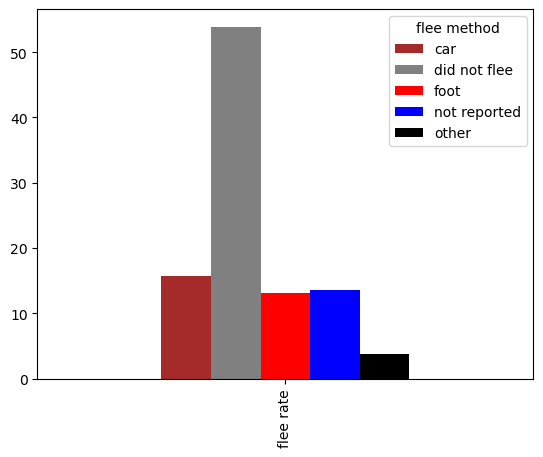

In [199]:
flee.T.plot(kind='bar', color=['brown', 'grey', 'red', 'blue', 'black'])